In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo

# Assignment 2: Recurrence and dynamics

For this assignment, the goal is to implement a simple accumulator model.  That is, we need a system that will decide which one of two actions it should perform, and it will take some time to do so.  It will make this choice based on a single input value, which gives some evidence as to which choice should be made.  It will indicate a choice by outputting either a 1 or a -1.  If that input evidence is positive, it will be more likely to make the first choice (1), and if the input evidence is negative it will be more likely to make the second choice (-1).

First, go through the built-in tutorials 10 through 18.  This will give you an overview of different recurrent systems and different ways of modifying ```Ensembles```.

We now start by building a recurrent system that can add up evidence over time (the accumulator).  This is a neural ```Ensemble``` that holds a single dimension, and uses a small number of neurons (50).  Provide it with one input ```Node``` that has a constant value of ```[0.1]``` and connect that input into the ```Ensemble```.  Now make a ```Connection``` from the ```Ensemble``` back to itself.  Since this ```Connection``` is accumulating evidence over time, we want it to be fairly stable, so set ```synape=0.1``` on this ```Connection```.  This means that the neurotransmitter being used will spread out over 100ms, rather than the default 5ms.

If you run the above system with a constant positive input, the value stored in the accumulator should gradually increase until it hits 1.  If you change the input to be negative, it should gradually decrease until it hits -1.

Building finished in 0:00:01.                                                                                                                                                                                                      
Simulating finished in 0:00:02.                                                                                                                                                                                                    


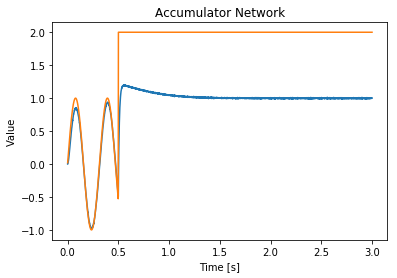

In [52]:
model = nengo.Network()

with model:
    #stim = nengo.Node([0])
    stim = nengo.Node(lambda t: np.sin(20*t) if t < 0.5 else 2)
    ensemble = nengo.Ensemble(n_neurons=1000, dimensions=1, radius=1)
    nengo.Connection(stim, ensemble, synapse=None)
    nengo.Connection(ensemble, ensemble, synapse=0.3, function=lambda x: -x)
    nengo.Connection(ensemble, ensemble, synapse=0.1, function=lambda x: -x)

    # probes
    inp = nengo.Probe(stim)  # The original input
    spikes = nengo.Probe(ensemble.neurons)  # The raw spikes from the neuron
    voltage = nengo.Probe(ensemble.neurons,'voltage')  # Subthreshold soma voltage of the neuron
    filtered = nengo.Probe(ensemble, synapse=0.01)  # Spikes filtered by a 10ms post-synaptic filter
    
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(3)

# Plot the decoded output of the ensemble
plt.plot(sim.trange(), sim.data[filtered])
plt.plot(sim.trange(), sim.data[inp])
plt.title("Accumulator Network")
plt.xlabel("Time [s]")
plt.ylabel("Value")
plt.show()

Next, we need to make the accumulator more random.  In a standard accumulator model, there is a "random-walk" component that randomly varies the value being accumulated.  We can model this by adding random noise into the ```Ensemble```.  The command for this is:

```python
acc.noise = nengo.processes.WhiteSignal(period=10, high=100, rms=3)
```

(where ```acc``` is whatever name you gave your accumulator ```Ensemble```.)

The strength of this noise is set by the ```rms=3``` parameter.  Try running the model with the noise ```rms=3```, and see what happens to the accumulated value.  Try increasing and decreasing the ```rms``` value and see whether the accumulator gets more or less noisy.

Building finished in 0:00:01.                                                                                                                                                                                                      
Simulating finished in 0:00:01.                                                                                                                                                                                                    
Building finished in 0:00:01.                                                                                                                                                                                                      
Simulating finished in 0:00:01.                                                                                                                                                                                                    
Building finished in 0:00:01.                                                           

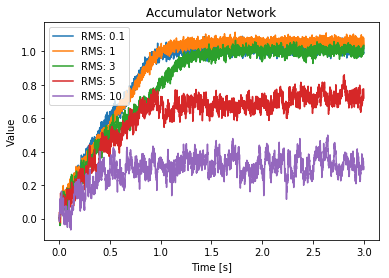

In [23]:
for rms in [0.1,1,3,5,10]:
    with model:
        ensemble.noise = nengo.processes.WhiteSignal(period=10, high=100, rms=rms)

    with nengo.Simulator(model) as sim:  # Create the simulator
        sim.run(3)

    # Plot the decoded output of the ensemble
    plt.plot(sim.trange(), sim.data[filtered], label="RMS: {}".format(rms))
    plt.title("Accumulator Network")
    plt.xlabel("Time [s]")
    plt.ylabel("Value")
plt.legend()
plt.show()

Finally, we want to determine when this accumulator passes some threshold.  If the value becomes large enough, we should make one choice (+1), and if it becomes small enough we should make the other choice (-1).  To achieve this, make a new output ```Ensemble``` that is also one-dimensional.  Form a ```Connection``` from the accumulator to this new ```Ensemble``` that computes the following function:

```python
def choice(x):
    if x[0] > 0.9:
        return 1
    elif x[0] < -0.9:
        return -1
    else: 
        return 0
```

This new output should now stay at zero until the accumulator value gets large enough, and then quickly move to +1 or -1.

Building finished in 0:00:01.                                                                                                                                                                                                      
Simulating finished in 0:00:02.                                                                                                                                                                                                    


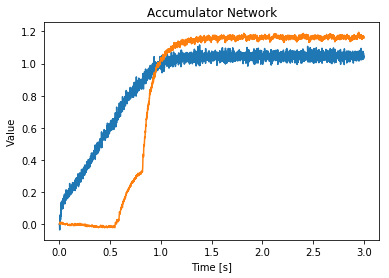

In [25]:
def choice(x):
    if x[0] > 0.9:
        return 1
    elif x[0] < -0.9:
        return -1
    else: 
        return 0

    
model = nengo.Network()

with model:
    #stim = nengo.Node([0])
    stim = nengo.Node([0.1])
    ensemble = nengo.Ensemble(n_neurons=50, dimensions=1, radius=1)
    nengo.Connection(stim, ensemble, synapse=0.005)
    nengo.Connection(ensemble, ensemble, synapse=0.1)

    # probes
    inp = nengo.Probe(stim)  # The original input
    spikes = nengo.Probe(ensemble.neurons)  # The raw spikes from the neuron
    voltage = nengo.Probe(ensemble.neurons,'voltage')  # Subthreshold soma voltage of the neuron
    filtered = nengo.Probe(ensemble, synapse=0.01)  # Spikes filtered by a 10ms post-synaptic filter
        
with model:
    threshold = nengo.Ensemble(n_neurons=50, dimensions=1, radius=1)
    output = nengo.Connection(ensemble, threshold, synapse=0.005, function=choice)
    output_probe = nengo.Probe(output, synapse=0.01)  # Spikes filtered by a 10ms post-synaptic filter

with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(3)

# Plot the decoded output of the ensemble
plt.plot(sim.trange(), sim.data[filtered])
plt.plot(sim.trange(), sim.data[output_probe])
plt.title("Accumulator Network")
plt.xlabel("Time [s]")
plt.ylabel("Value")
plt.show()

In [20]:
help(nengo.Ensemble)

Help on class Ensemble in module nengo.ensemble:

class Ensemble(nengo.base.NengoObject)
 |  A group of neurons that collectively represent a vector.
 |  
 |  Parameters
 |  ----------
 |  n_neurons : int
 |      The number of neurons.
 |  dimensions : int
 |      The number of representational dimensions.
 |  
 |  radius : int, optional (Default: 1.0)
 |      The representational radius of the ensemble.
 |  encoders : Distribution or (n_neurons, dimensions) array_like, optional                (Default: UniformHypersphere(surface=True))
 |      The encoders used to transform from representational space
 |      to neuron space. Each row is a neuron's encoder; each column is a
 |      representational dimension.
 |  intercepts : Distribution or (n_neurons,) array_like, optional                  (Default: ``nengo.dists.Uniform(-1.0, 1.0)``)
 |      The point along each neuron's encoder where its activity is zero. If
 |      ``e`` is the neuron's encoder, then the activity will be zero whe

## Extension 1

The output from this choice is not particularly clean.  It would be nice if it stayed at exactly zero until a choice was completely made.  We can do this by changing the tuning curves for the neurons in the choice population.  In particular, we can make them only fire at all for larger values:

```output.intercepts = nengo.dists.Uniform(0.7, 0.9)```

Make this change and see how this affects the performance of the system.  You can look at the tuning curves by right-clicking on an ```Ensemble``` and selecting ```Details...``` and choosing ```Plots```.

## Extension 2

It is also possible to combine the two Ensembles used here into a single 2-dimensional Ensemble.  The Connections are made similarly, but they need to target the particular dimensions involved using the ```ens[0]``` and ```ens[1]``` syntax.  Try building the model this way.  How does this change the performance of the system?